#### ДЗ_34  - TensorRT
#### Татур А.А.
##### 13.04.2023

#### Выполнить квантование уже имеющейся модели (в качестве модели взята VGG16 + Attention из предыдущей работы)

In [2]:
import numpy as np
import pandas as pd
import cv2
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import matplotlib.pyplot as plt
import onnx, tf2onnx
import tensorrt as trt
import gc
from tensorflow.keras.models import load_model
from tensorflow import saved_model

import tensorrt as trt
import pycuda.driver as cuda
import pycuda.autoinit

#### Загружаем датасет с изображениями

In [3]:
df = pd.read_csv ('data_UTK.csv')
train, test = train_test_split(df, test_size=0.2, random_state=34)

#### Загружаем предобученную модель

In [127]:
own_model = load_model("own_model.h5")

In [164]:
own_model.summary()

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_82 (Conv2D)          (None, 128, 128, 64)      1792      
                                                                 
 max_pooling2d_82 (MaxPoolin  (None, 64, 64, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_83 (Conv2D)          (None, 64, 64, 128)       73856     
                                                                 
 max_pooling2d_83 (MaxPoolin  (None, 32, 32, 128)      0         
 g2D)                                                            
                                                                 
 conv2d_84 (Conv2D)          (None, 32, 32, 256)       295168    
                                                                 
 max_pooling2d_84 (MaxPoolin  (None, 16, 16, 256)    

#### Засекаем время предсказания 1000 изображений

In [128]:
NUM_IMAGES = 1000
idx = np.random.randint (0,len(test),NUM_IMAGES)

for idx in tqdm(enumerate(idx), desc='Prediction'):
    link = test.iloc[idx[1]]
    image = plt.imread(link[0])
    img_resized = cv2.resize (image, (128,128))/255 #,
    img_reshaped  = img_resized.reshape (1,128,128,3)
    predict = own_model.predict(img_reshaped, verbose=0)[0][0];

Prediction: 1000it [01:26, 11.56it/s]


In [212]:
del own_model
gc.collect()

134864

#### Конвертируем модель в ONNX формат

In [10]:
!python -m tf2onnx.convert --saved-model tmp_model --output temp.onnx

C:\Users\ratua\anaconda3\envs\TensorRT\lib\runpy.py:127: RuntimeWarning: 'tf2onnx.convert' found in sys.modules after import of package 'tf2onnx', but prior to execution of 'tf2onnx.convert'; this may result in unpredictable behaviour
  warn(RuntimeWarning(msg))
2023-04-13 15:10:02,678 - WARNING - '--tag' not specified for saved_model. Using --tag serve
2023-04-13 15:10:03,326 - INFO - Signatures found in model: [serving_default].
2023-04-13 15:10:03,326 - WARNING - '--signature_def' not specified, using first signature: serving_default
2023-04-13 15:10:03,326 - INFO - Output names: ['dense_51']
2023-04-13 15:10:03,970 - INFO - Using tensorflow=2.10.1, onnx=1.13.0, tf2onnx=1.14.0/8f8d49
2023-04-13 15:10:03,970 - INFO - Using opset <onnx, 15>
2023-04-13 15:10:04,157 - INFO - Computed 0 values for constant folding
2023-04-13 15:10:04,391 - INFO - Optimizing ONNX model
2023-04-13 15:10:04,939 - INFO - After optimization: GlobalMaxPool +1 (0->1), Identity -2 (2->0), ReduceMax -1 (1->0), Sq

In [11]:
onnx_model = onnx.load_model('temp.onnx');

#### Меняем размер батча и сохраняем модель

In [20]:
BATCH_SIZE=1
target_dtype = np.float32

In [13]:
inputs = onnx_model.graph.input
for input in inputs:
    dim1 = input.type.tensor_type.shape.dim[0]
    dim1.dim_value = BATCH_SIZE
    
model_name = "own_model.onnx"
onnx.save_model(onnx_model, model_name)
print("Done saving!")

Done saving!


#### Конвертируем в trt

In [1]:
!trtexec --onnx=own_model.onnx --saveEngine=own_model.trt  --explicitBatch

&&&& RUNNING TensorRT.trtexec [TensorRT v8503] # trtexec --onnx=own_model.onnx --saveEngine=own_model.trt --explicitBatch
[04/13/2023-15:26:01] [I] === Model Options ===
[04/13/2023-15:26:01] [I] Format: ONNX
[04/13/2023-15:26:01] [I] Model: own_model.onnx
[04/13/2023-15:26:01] [I] Output:
[04/13/2023-15:26:01] [I] === Build Options ===
[04/13/2023-15:26:01] [I] Max batch: explicit batch
[04/13/2023-15:26:01] [I] Memory Pools: workspace: default, dlaSRAM: default, dlaLocalDRAM: default, dlaGlobalDRAM: default
[04/13/2023-15:26:01] [I] minTiming: 1
[04/13/2023-15:26:01] [I] avgTiming: 8
[04/13/2023-15:26:01] [I] Precision: FP32
[04/13/2023-15:26:01] [I] LayerPrecisions: 
[04/13/2023-15:26:01] [I] Calibration: 
[04/13/2023-15:26:01] [I] Refit: Disabled
[04/13/2023-15:26:01] [I] Sparsity: Disabled
[04/13/2023-15:26:01] [I] Safe mode: Disabled
[04/13/2023-15:26:01] [I] DirectIO mode: Disabled
[04/13/2023-15:26:01] [I] Restricted mode: Disabled
[04/13/2023-15:26:01] [I] Build only: Disabled

[04/13/2023-15:26:01] [W] --explicitBatch flag has been deprecated and has no effect!
[04/13/2023-15:26:01] [W] Explicit batch dim is automatically enabled if input model is ONNX or if dynamic shapes are provided when the engine is built.
[04/13/2023-15:26:06] [W] [TRT] CUDA lazy loading is not enabled. Enabling it can significantly reduce device memory usage. See `CUDA_MODULE_LOADING` in https://docs.nvidia.com/cuda/cuda-c-programming-guide/index.html#env-vars
[04/13/2023-15:26:06] [W] [TRT] onnx2trt_utils.cpp:377: Your ONNX model has been generated with INT64 weights, while TensorRT does not natively support INT64. Attempting to cast down to INT32.
[04/13/2023-15:26:15] [W] [TRT] CUDA lazy loading is not enabled. Enabling it can significantly reduce device memory usage. See `CUDA_MODULE_LOADING` in https://docs.nvidia.com/cuda/cuda-c-programming-guide/index.html#env-vars
[04/13/2023-15:26:19] [W] * GPU compute time is unstable, with coefficient of variance = 8.65841%.
[04/13/2023-15:

#### Заружаем trt файл

In [5]:
f = open("own_model.trt", "rb")
runtime = trt.Runtime(trt.Logger(trt.Logger.WARNING)) 
engine = runtime.deserialize_cuda_engine(f.read())
context = engine.create_execution_context()

#### Функция предикта

In [6]:
def predict(batch):
    cuda.memcpy_htod_async(d_input, batch, stream)
    context.execute_async_v2(bindings, stream.handle, None)
    cuda.memcpy_dtoh_async(output, d_output, stream)
    stream.synchronize()    
    return output

#### Проверяем работу

Prediction: 25it [00:00, 30.66it/s]


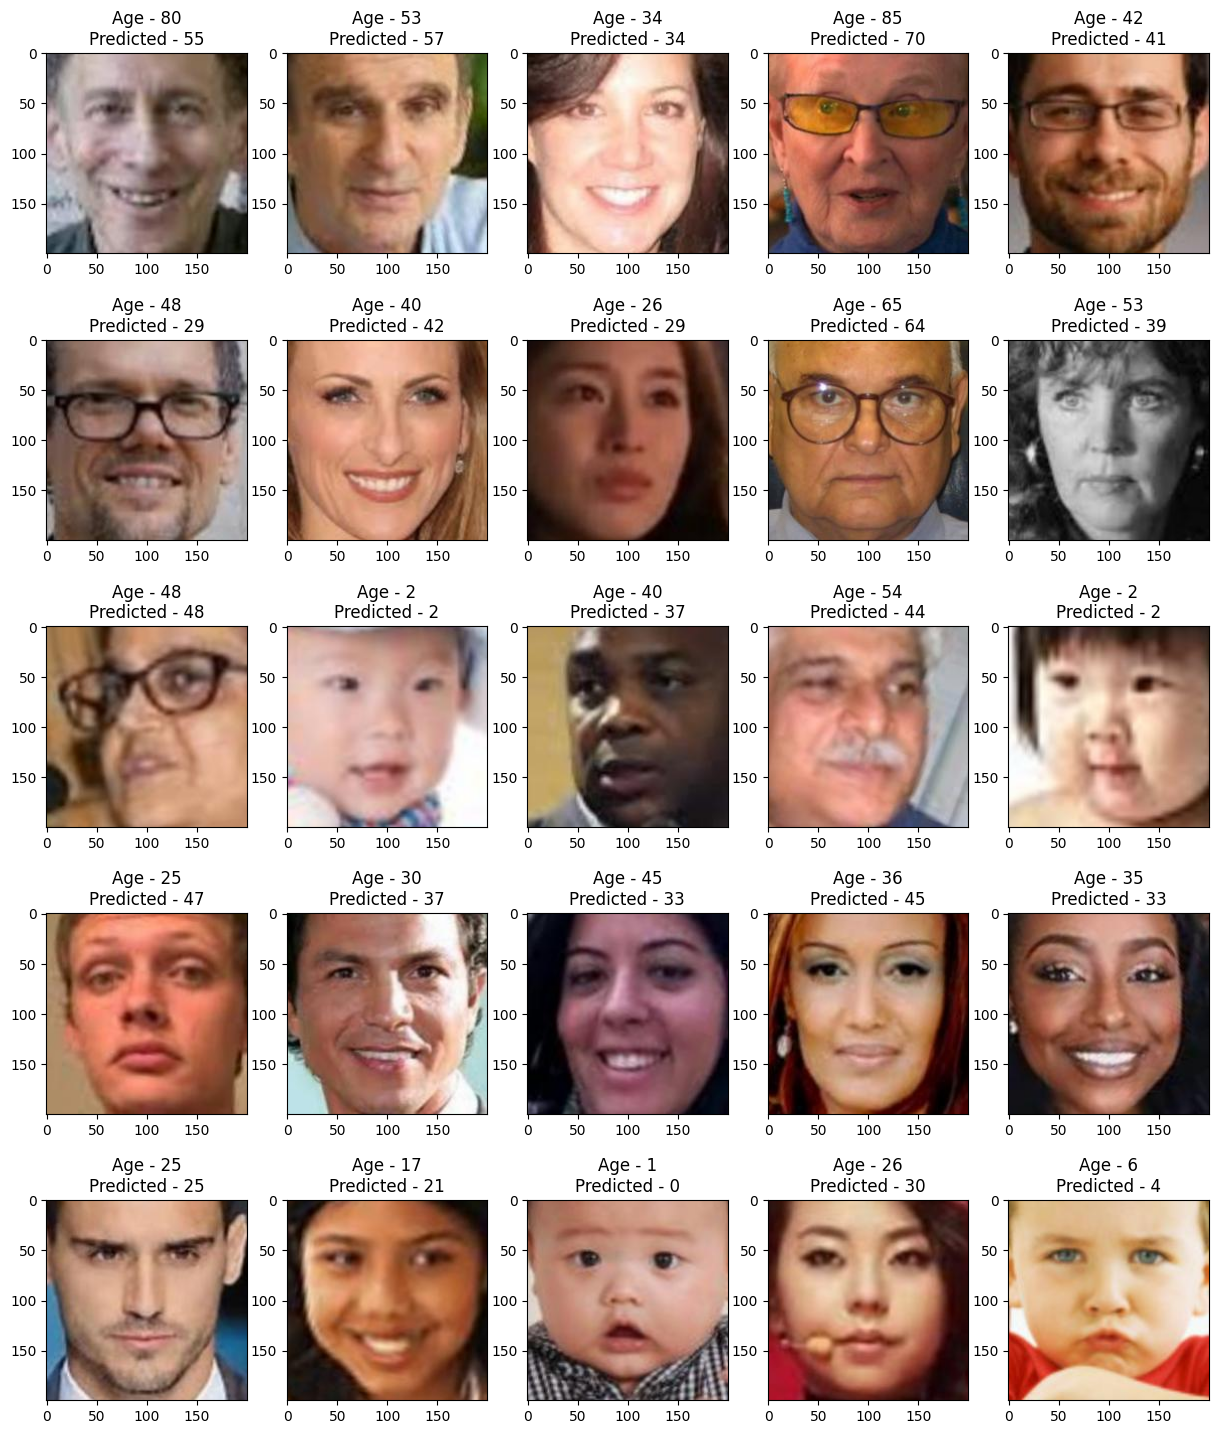

In [124]:
NUM_IMAGES = 25
idx = np.random.randint (0,len(test),NUM_IMAGES)
plt.figure(figsize=(15,18))

for idx in tqdm(enumerate(idx), desc='Prediction'):
    
    plt.subplot (5,5,idx[0]+1)
    
    link = test.iloc[idx[1]]
    image = plt.imread(link[0])
    img_resized = cv2.resize (image, (128,128))/255 #,
    img_reshaped  = img_resized.reshape (1,128,128,3)
    
    input_batch = np.array(np.repeat(np.expand_dims(np.array(img_reshaped, dtype=np.float32), axis=0), BATCH_SIZE, axis=0), dtype=np.float32)
       
    output = np.empty([BATCH_SIZE, 1], dtype = target_dtype)

    d_input = cuda.mem_alloc(1 * input_batch.nbytes)
    d_output = cuda.mem_alloc(1 * output.nbytes)

    bindings = [int(d_input), int(d_output)]

    stream = cuda.Stream()
    
    trt_predictions = predict(input_batch).astype(np.float32)
    
    title = 'Age - ' + str(link[1]) + '\nPredicted - ' + str(int(trt_predictions[0][0]))
    plt.title (title)
    plt.imshow(image, cmap='gray');

#### Проверяем Скорость

In [126]:
NUM_IMAGES = 1000
idx = np.random.randint (0,len(test),NUM_IMAGES)

for idx in tqdm(enumerate(idx), desc='Prediction'):

    link = test.iloc[idx[1]]
    image = plt.imread(link[0])
    img_resized = cv2.resize (image, (128,128))/255 #,
    img_reshaped  = img_resized.reshape (1,128,128,3)
    
    input_batch = np.array(np.repeat(np.expand_dims(np.array(img_reshaped, dtype=np.float32), axis=0), BATCH_SIZE, axis=0), dtype=np.float32)
       
    output = np.empty([BATCH_SIZE, 1], dtype = target_dtype)

    d_input = cuda.mem_alloc(1 * input_batch.nbytes)
    d_output = cuda.mem_alloc(1 * output.nbytes)

    bindings = [int(d_input), int(d_output)]

    stream = cuda.Stream()
    
    trt_predictions = predict(input_batch).astype(np.float32)

Prediction: 1000it [00:06, 158.30it/s]


#### Вывод

In [ ]:
Применение TensorRT позволило значительно ускорить работу модели, с более чем 1 минуты на 1000 итераций, до 6 секунд.